# Data Loading, Pre-Processing
# Data Exploration

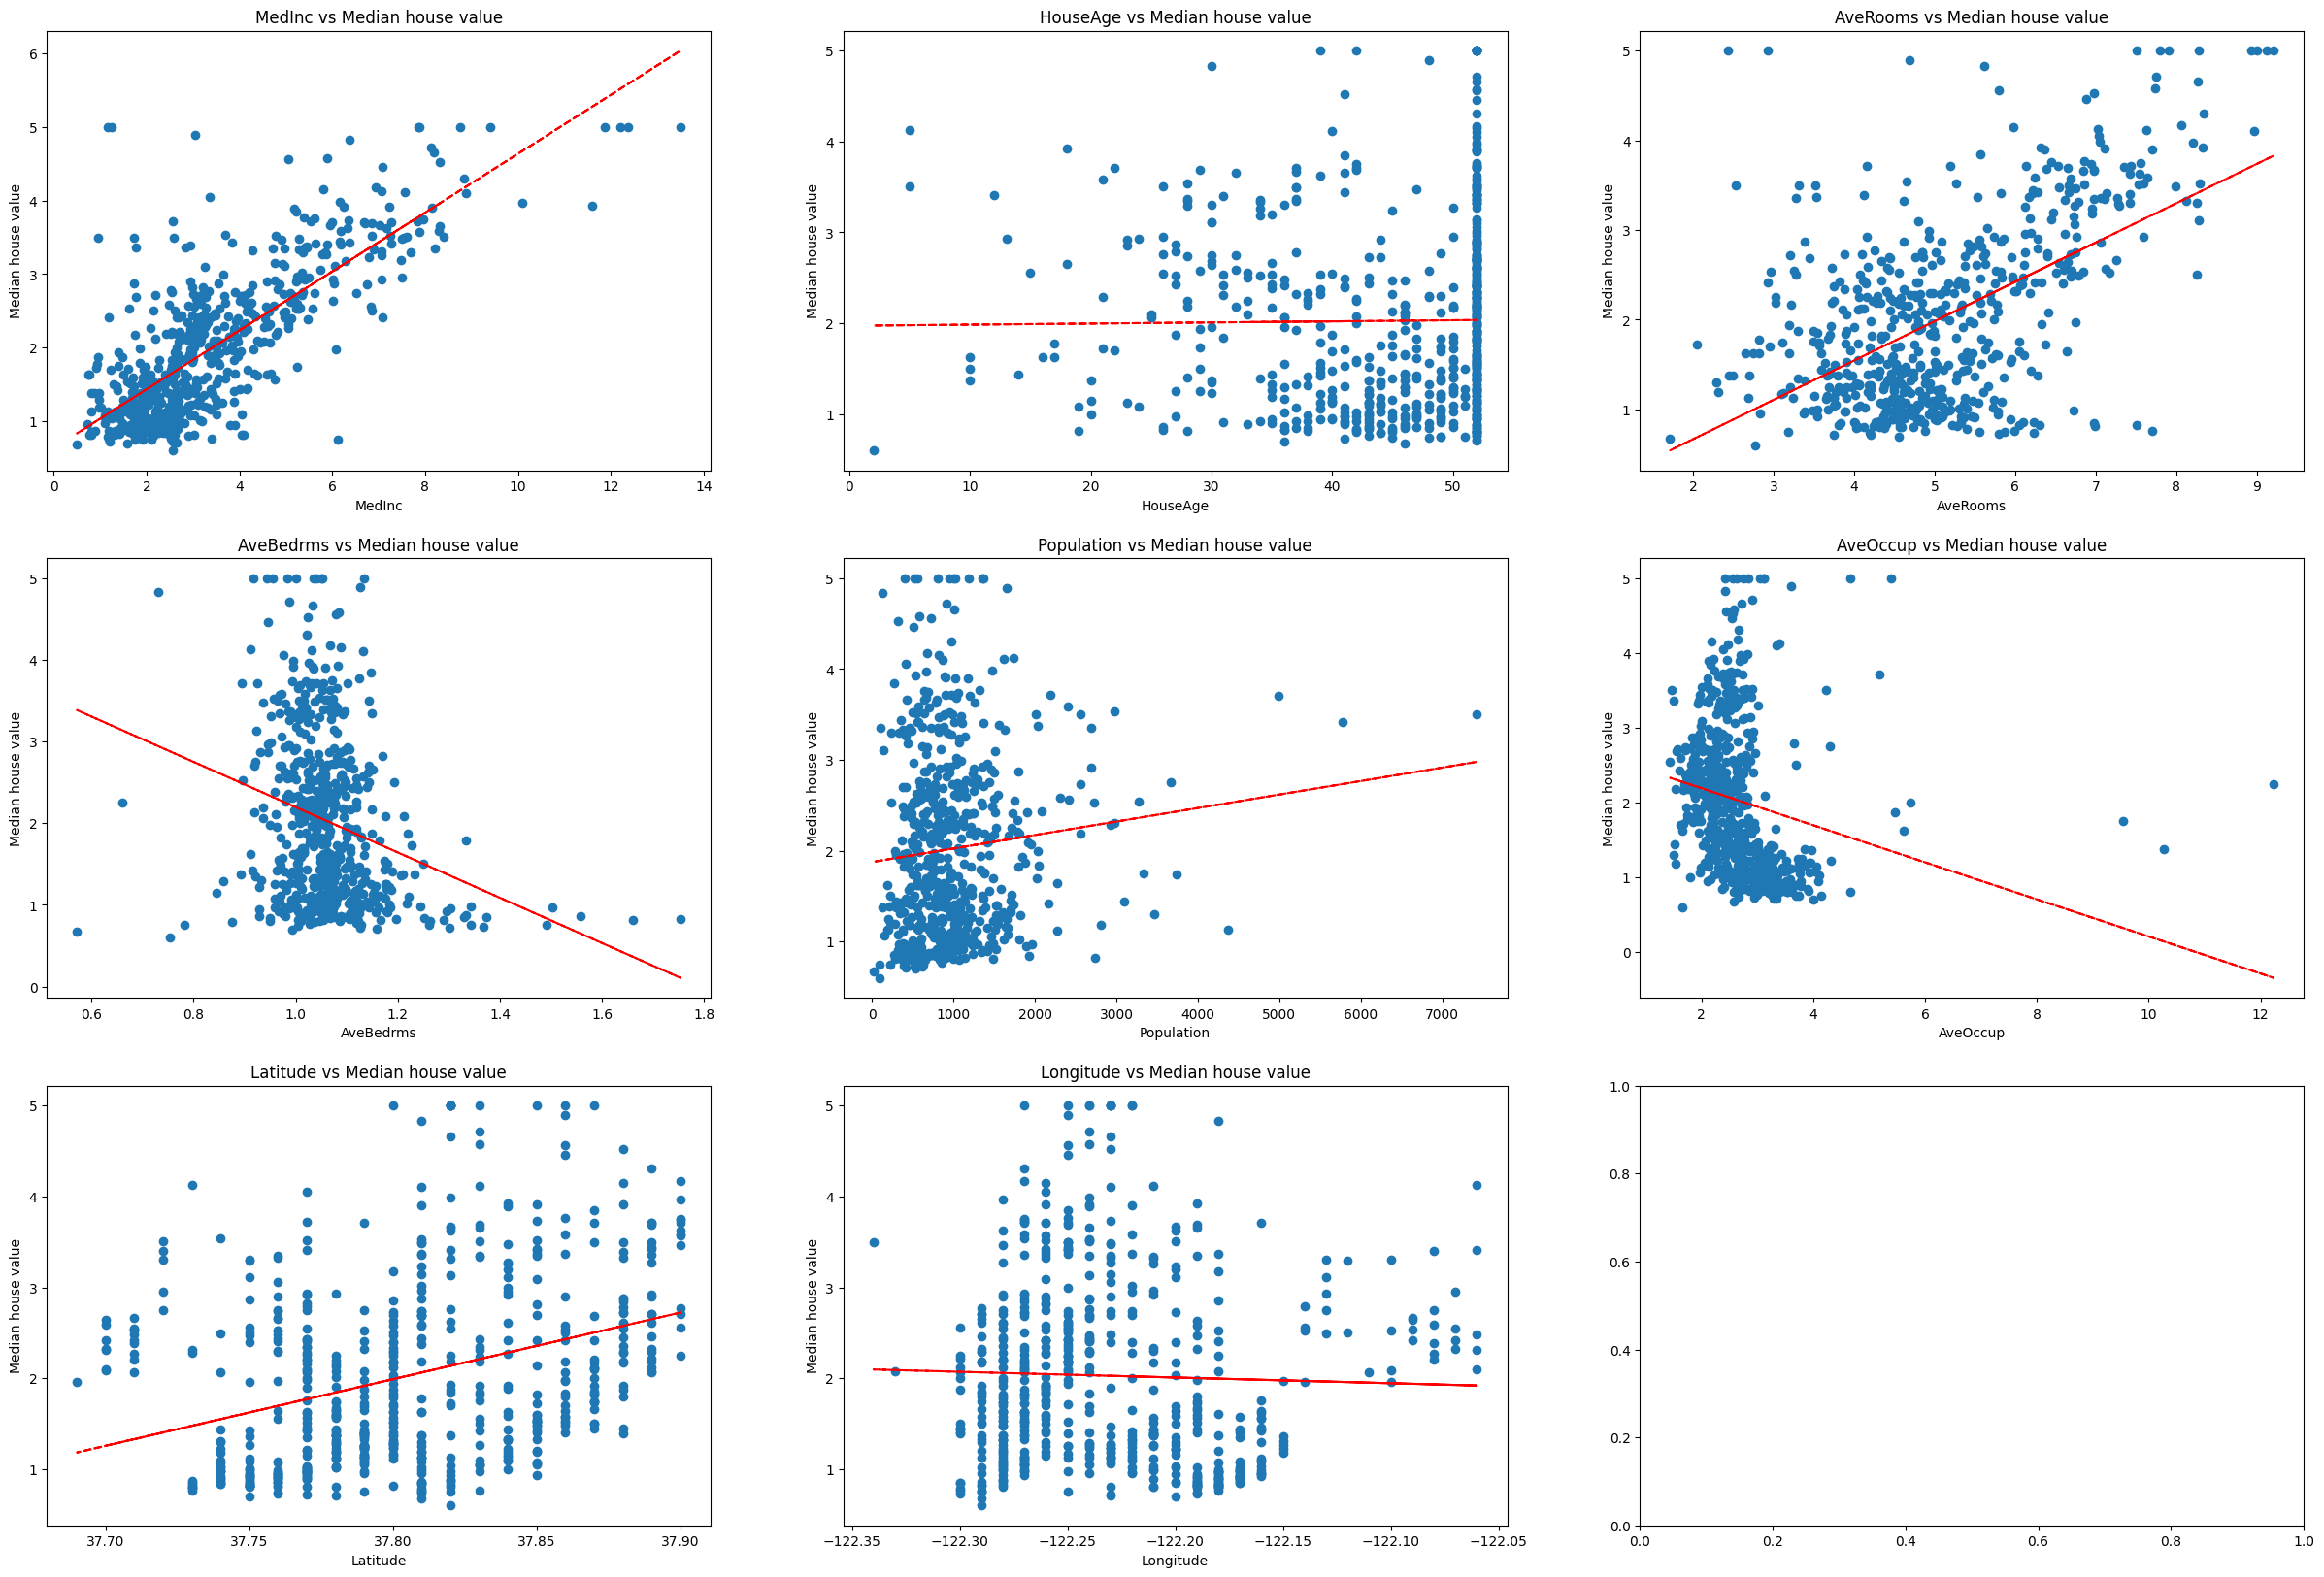

In [1]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing
from captum.attr import DeepLift,NoiseTunnel,GradientShap,FeatureAblation,LayerConductance,IntegratedGradients
import torch,numpy as np,torch.nn as nn,matplotlib.pyplot as plt
california=fetch_california_housing()
feature_names=california.feature_names
n=600
X=california.data[:n]
y=california.target[:n]
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=0)
fig,axs=plt.subplots(nrows=3,
                     ncols=3,
                     figsize=(30,20))
for i,(ax,col) in enumerate(zip(axs.flat,feature_names)):    
    x=X[:,i]
    pf=np.polyfit(x,y,1)
    p=np.poly1d(pf)
    ax.plot(x,y,'o')
    ax.plot(x,p(x),'r--')
    ax.set_title(col+' vs Median house value')
    ax.set_xlabel(col)
    ax.set_ylabel('Median house value')

# Tensorizing Inputs, Creating Batches

In [2]:
X_train=torch.tensor(X_train).float()
y_train=torch.tensor(y_train).view(-1,1).float()
X_test=torch.tensor(X_test).float()
y_test=torch.tensor(y_test).view(-1,1).float()
datasets=torch.utils.data.TensorDataset(X_train,y_train)
train_iter=torch.utils.data.DataLoader(datasets,batch_size=10,shuffle=True)
batch_size=50
num_epochs=200
learning_rate=0.0001
size_hidden1=100
size_hidden2=50
size_hidden3=10
size_hidden4=1
class CaliforniaModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1=nn.Linear(8,size_hidden1)
        self.relu1=nn.ReLU()
        self.lin2=nn.Linear(size_hidden1,size_hidden2)
        self.relu2=nn.ReLU()
        self.lin3=nn.Linear(size_hidden2,size_hidden3)
        self.relu3=nn.ReLU()
        self.lin4=nn.Linear(size_hidden3,size_hidden4)
    def forward(self,input):
        return self.lin4(self.relu3(self.lin3(self.relu2(self.lin2(self.relu1(self.lin1(input)))))))
model=CaliforniaModel()
model.train()

CaliforniaModel(
  (lin1): Linear(in_features=8, out_features=100, bias=True)
  (relu1): ReLU()
  (lin2): Linear(in_features=100, out_features=50, bias=True)
  (relu2): ReLU()
  (lin3): Linear(in_features=50, out_features=10, bias=True)
  (relu3): ReLU()
  (lin4): Linear(in_features=10, out_features=1, bias=True)
)

# Train California Model

In [3]:
criterion=nn.MSELoss(reduction='sum')
def train(model_inp,num_epochs=num_epochs):
    optimizer=torch.optim.RMSprop(model_inp.parameters(),lr=learning_rate)
    for epoch in range(num_epochs):
        running_loss=0
        for inputs,labels in train_iter:
            outputs=model_inp(inputs)
            loss=criterion(outputs,labels)
            optimizer.zero_grad()
            loss.backward()
            running_loss+=loss.item()
            optimizer.step()
        if epoch%20==0:    
            print(f'Epoch [{epoch+1}]/[{num_epochs}] running accumulative loss across all batches: {running_loss:.3f}')
        running_loss=0
def train_save_model(model_obj,model_path):
    train(model_obj)
    print(f'Finished training the model.\nSaving the model to: {model_path}')
    torch.save(model_obj.state_dict(),model_path)
SAVED_MODEL_PATH='california_model.pt'
train_save_model(model,SAVED_MODEL_PATH)

Epoch [1]/[200] running accumulative loss across all batches: 1304.992
Epoch [21]/[200] running accumulative loss across all batches: 431.877
Epoch [41]/[200] running accumulative loss across all batches: 409.358
Epoch [61]/[200] running accumulative loss across all batches: 368.765
Epoch [81]/[200] running accumulative loss across all batches: 329.820
Epoch [101]/[200] running accumulative loss across all batches: 289.510
Epoch [121]/[200] running accumulative loss across all batches: 264.318
Epoch [141]/[200] running accumulative loss across all batches: 230.257
Epoch [161]/[200] running accumulative loss across all batches: 212.389
Epoch [181]/[200] running accumulative loss across all batches: 200.423
Finished training the model.
Saving the model to: california_model.pt


In [4]:
model.eval()
outputs=model(X_test)
err=np.sqrt(mean_squared_error(outputs.detach().numpy(),
                               y_test.detach().numpy()))
print(f'Model err: {err}')

Model err: 0.7020461600864327


# Comparing Different Attribution Algorithms

/Users/I568200/.pyenv/versions/Environment/lib/python3.14/site-packages/captum/attr/_core/deep_lift.py:294: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  gradient_mask = apply_gradient_requirements(inputs_tuple)
/Users/I568200/.pyenv/versions/Environment/lib/python3.14/site-packages/captum/log/dummy_log.py:39: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  return func(*args, **kwargs)


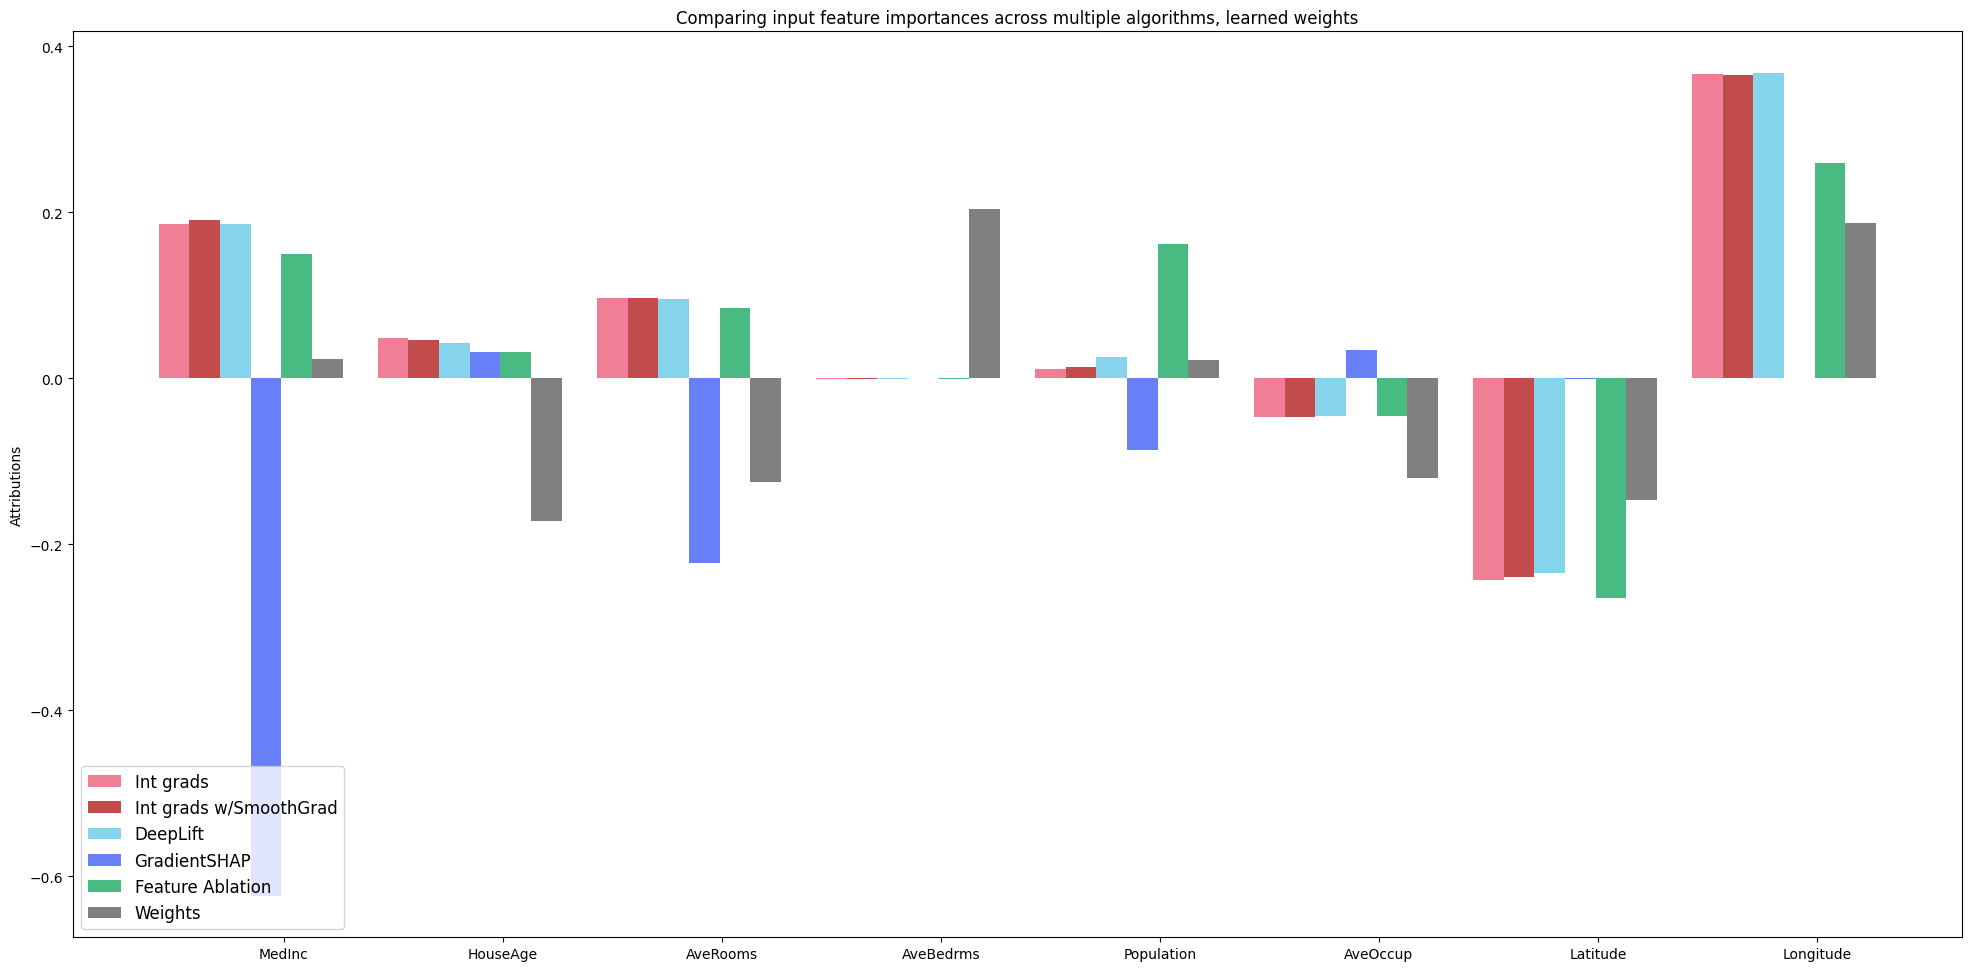

In [5]:
ig=IntegratedGradients(model)
ig_nt=NoiseTunnel(ig)
dl=DeepLift(model)
gs=GradientShap(model)
fa=FeatureAblation(model)
ig_attr_test=ig.attribute(X_test,n_steps=50)
ig_nt_attr_test=ig_nt.attribute(X_test)
dl_attr_test=dl.attribute(X_test)
gs_attr_test=gs.attribute(X_test,X_train)
fa_attr_test=fa.attribute(X_test)
x_axis_data=np.arange(X_test.shape[1])
x_axis_data_labels=list(map(lambda idx:feature_names[idx],x_axis_data))
ig_attr_test_sum=ig_attr_test.detach().numpy().sum(0)
ig_attr_test_norm_sum=ig_attr_test_sum/np.linalg.norm(ig_attr_test_sum,ord=1)
ig_nt_attr_test_sum=ig_nt_attr_test.detach().numpy().sum(0)
ig_nt_attr_test_norm_sum=ig_nt_attr_test_sum/np.linalg.norm(ig_nt_attr_test_sum,ord=1)
dl_attr_test_sum=dl_attr_test.detach().numpy().sum(0)
dl_attr_test_norm_sum=dl_attr_test_sum/np.linalg.norm(dl_attr_test_sum,ord=1)
gs_attr_test_sum=gs_attr_test.detach().numpy().sum(0)
gs_attr_test_norm_sum=gs_attr_test_sum/np.linalg.norm(gs_attr_test_sum,ord=1)
fa_attr_test_sum=fa_attr_test.detach().numpy().sum(0)
fa_attr_test_norm_sum=fa_attr_test_sum/np.linalg.norm(fa_attr_test_sum,ord=1)
lin_weight=model.lin1.weight[0].detach().numpy()
y_axis_lin_weight=lin_weight/np.linalg.norm(lin_weight,ord=1)
width=0.14
legends=['Int grads','Int grads w/SmoothGrad','DeepLift','GradientSHAP','Feature Ablation','Weights']
plt.figure(figsize=(20,10))
ax=plt.subplot()
ax.set_title('Comparing input feature importances across multiple algorithms, learned weights')
ax.set_ylabel('Attributions')
FONT_SIZE=16
plt.rc('font',size=FONT_SIZE)
plt.rc('axes',titlesize=FONT_SIZE)
plt.rc('axes',labelsize=FONT_SIZE)
plt.rc('legend',fontsize=FONT_SIZE-4)
ax.bar(x_axis_data,ig_attr_test_norm_sum,width,align='center',alpha=0.8,color='#eb5e7c')
ax.bar(x_axis_data+width,ig_nt_attr_test_norm_sum,width,align='center',alpha=0.7,color='#A90000')
ax.bar(x_axis_data+2*width,dl_attr_test_norm_sum,width,align='center',alpha=0.6,color='#34b8e0')
ax.bar(x_axis_data+3*width,gs_attr_test_norm_sum,width,align='center',alpha=0.8,color='#4260f5')
ax.bar(x_axis_data+4*width,fa_attr_test_norm_sum,width,align='center',alpha=1,color='#49ba81')
ax.bar(x_axis_data+5*width,y_axis_lin_weight,width,align='center',alpha=1,color='grey')
ax.autoscale_view()
plt.tight_layout()
ax.set_xticks(x_axis_data+0.5)
ax.set_xticklabels(x_axis_data_labels)
plt.legend(legends,loc=3)
plt.show()

# Attributing To Layers, Comparing With Model Weights

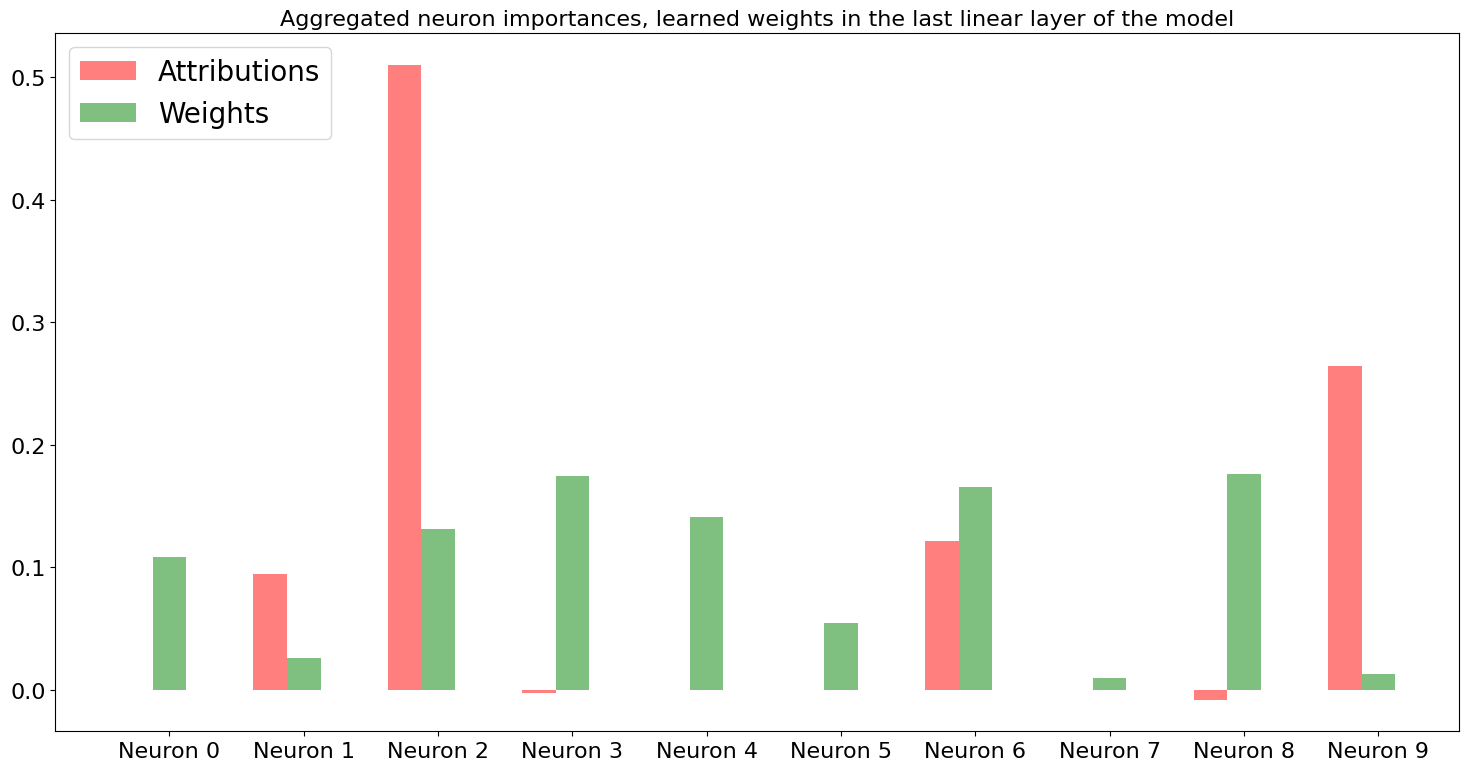

In [6]:
lc=LayerConductance(model,model.lin4)
lc_attr_test=lc.attribute(X_test,n_steps=100,attribute_to_layer_input=True)
lin4_weight=model.lin4.weight
plt.figure(figsize=(15,8))
x_axis_data=np.arange(lc_attr_test.shape[1])
y_axis_lc_attr_test=lc_attr_test.mean(0).detach().numpy()
y_axis_lc_attr_test=y_axis_lc_attr_test/np.linalg.norm(y_axis_lc_attr_test,ord=1)
y_axis_lin4_weight=lin4_weight[0].detach().numpy()
y_axis_lin4_weight=y_axis_lin4_weight/np.linalg.norm(y_axis_lin4_weight,ord=1)
width=0.25
legends=['Attributions','Weights']
x_axis_labels=['Neuron {}'.format(i) for i in range(len(y_axis_lin4_weight))]
ax=plt.subplot()
ax.set_title('Aggregated neuron importances, learned weights in the last linear layer of the model')
ax.bar(x_axis_data+width,y_axis_lc_attr_test,width,align='center',alpha=0.5,color='red')
ax.bar(x_axis_data+2*width,y_axis_lin4_weight,width,align='center',alpha=0.5,color='green')
plt.legend(legends,loc=2,prop={'size':20})
ax.autoscale_view()
plt.tight_layout()
ax.set_xticks(x_axis_data+0.5)
ax.set_xticklabels(x_axis_labels)
plt.show()